In [ ]:
%pip install svetlanna
%pip install reservoirpy matplotlib tqdm requests av scikit-image py-cpuinfo gputil pandas

In [1]:
import torch
from svetlanna import elements
from svetlanna import SimulationParameters
from svetlanna import Parameter
import matplotlib.pyplot as plt
from svetlanna import wavefront as w
from svetlanna.units import ureg

# Use of a nonlinear element

The nonlinear element allows to control the intensity of the incident wavefront while preserving the phase distribution. For the aim to define the nonlinear element, it's necessary to pass the intensity ```response_function```. For example, we will use the sigmoid function as a response function and the gaussian beam as an incident wavefront:

In [2]:
def response_sigmoid(x):
    return 10 / (1 + torch.exp(-x)) - 5

## Creating numerical mesh with using `SimulationParameters` class

In [3]:
wavelength = 1064 * ureg.nm # wavelength, mm
lx = 15 * ureg.mm # screen size along x-axis, mm
ly = 8 * ureg.mm # screen size along y-axis, mm

Nx = 1200 # number of nodes along x-axis
Ny = 1100 # number of nodes along y-axis

x_length = torch.linspace(-lx / 2, lx / 2, Nx)
y_length = torch.linspace(-ly / 2, ly / 2, Ny)

# define simulation parameters
params = SimulationParameters(
    axes={
            'W': x_length,
            'H': y_length,
            'wavelength': wavelength
        }
)
xv, yv = params.meshgrid(x_axis='W', y_axis='H')


## Creating a Gaussian beam using `svetlanna.wavefront.gaussian_beam`

Let's create a Gaussian beam that will fall on the nonlinear element:

In [4]:
incident_wavefront = w.Wavefront.gaussian_beam(
    simulation_parameters=params,
    waist_radius=2. * ureg.mm,
    distance=10 * ureg.cm
)
intensity_input = incident_wavefront.intensity

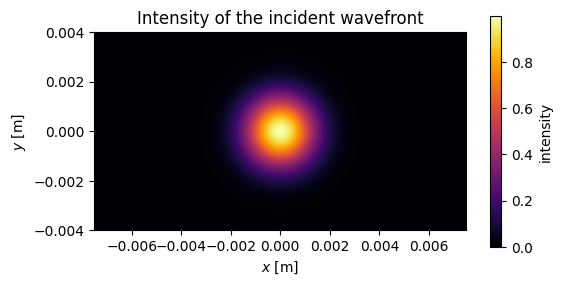

In [5]:
fig, ax = plt.subplots(figsize=(6, 3))
im1 = ax.pcolormesh(xv, yv, intensity_input, cmap='inferno')
ax.set_aspect('equal')
ax.set_title('Intensity of the incident wavefront')
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$y$ [m]')
fig.colorbar(im1, label='intensity')

## Creating nonlinear element using `svetlanna.elements.NonlinearElement`

In this section we will create a nonlinear element with determined intensity response_function:

In [6]:
nl_element = elements.NonlinearElement(
    simulation_parameters=params,
    response_function=response_sigmoid
)

transmitted_wavefront = nl_element.forward(incident_wavefront=incident_wavefront)
intensity_output = transmitted_wavefront.intensity

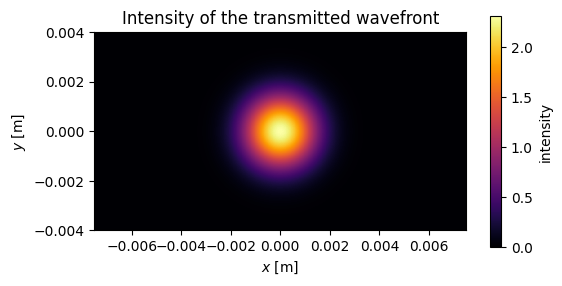

In [7]:
fig, ax = plt.subplots(figsize=(6, 3))
im1 = ax.pcolormesh(xv, yv, intensity_output, cmap='inferno')
ax.set_aspect('equal')
ax.set_title('Intensity of the transmitted wavefront')
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$y$ [m]')
fig.colorbar(im1, label='intensity')

Text(0, 0.5, '$intesnity$')

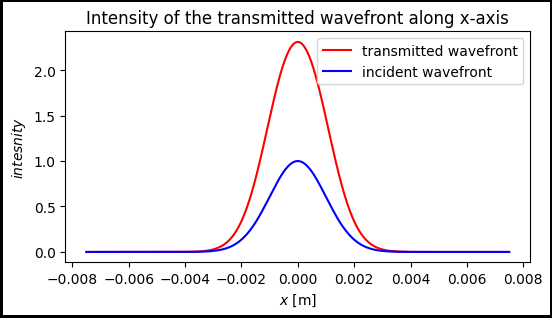

In [8]:
fig, ax = plt.subplots(figsize=(6, 3), edgecolor='black', linewidth=3,
                       frameon=True)

ax.set_title("Intensity of the transmitted wavefront along x-axis")
ax.plot(xv[int(Ny/2)], intensity_output[int(Ny/2)], color='red', label="transmitted wavefront")
ax.plot(xv[int(Ny/2)], intensity_input[int(Ny/2)], color='blue', label="incident wavefront")
ax.legend()
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$intesnity$')


## Training the parameters of the response function

If it's necessary to train parameters of the response function, you can pass them into nonlinear element `__init__` method using `Dict` and `Parameter object`. Parameter of other types can not be trained.

In [9]:
def arbitrary_function(x, parameter1, parameter2, parameter3):
    return parameter1 / (1 + torch.exp(-x * parameter2)) + parameter3 - 150

nl_to_train = elements.NonlinearElement(
    simulation_parameters=params,
    response_function=arbitrary_function,
    response_parameters={
        "parameter1": Parameter(100.),
        "parameter2": Parameter(40.),
        "parameter3": 100.
    }
)

output_field_to_train = nl_to_train.forward(incident_wavefront=incident_wavefront)
intensity_output_to_train = output_field_to_train.intensity

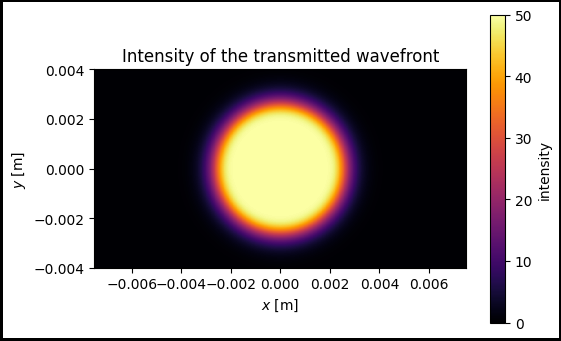

In [10]:
fig, ax = plt.subplots(figsize=(6, 4), edgecolor='black', linewidth=3,
                       frameon=True)
im1 = ax.pcolormesh(xv, yv, intensity_output_to_train.detach(), cmap='inferno')
ax.set_aspect('equal')
ax.set_title('Intensity of the transmitted wavefront')
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$y$ [m]')
fig.colorbar(im1, label='intensity')

Text(0, 0.5, '$intesnity$')

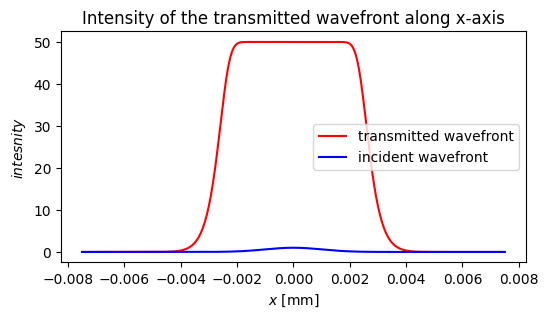

In [11]:
fig, ax = plt.subplots(figsize=(6, 3))

ax.set_title("Intensity of the transmitted wavefront along x-axis")
ax.plot(xv[int(Ny/2)], intensity_output_to_train[int(Ny/2)].detach(), color='red', label="transmitted wavefront")
ax.plot(xv[int(Ny/2)], intensity_input[int(Ny/2)], color='blue', label="incident wavefront")
ax.legend()
ax.set_xlabel('$x$ [mm]')
ax.set_ylabel('$intesnity$')